In [1]:
import json
from pprint import pprint
import ijson
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
FN = 'vocabulary-embedding'
seed = 42

In [3]:
with open('signalmedia-1m.jsonl') as f:
    mylist = [line.rstrip('\n') for line in f]

In [4]:
def get_dataframe(mylist,n_article):
    title = []
    content = []
    for line in mylist[:n_article]:
        d = json.loads(line)
        title.append(d['title'].lower())
        content.append(d['content'].lower())        
    title = pd.DataFrame(title,columns = ['title'])
    content = pd.DataFrame(content,columns = ['content'])
    data = pd.concat([title,content], axis = 1)   
    return data

In [168]:
len(mylist)

1000000

In [169]:
data = get_dataframe(mylist,10000)

In [170]:
def tokenize(data):
    punc = string.punctuation 
    for p in punc:
        data = data.replace(p, ' {} '.format(p))
        data = data.replace('  ',' ')
    return data

In [171]:
data.insert(data.shape[1],'content_token',data.content.apply(tokenize))
data.insert(data.shape[1],'title_token',data.title.apply(tokenize))
data.head()

,title,content,content_token,title_token
0,worcester breakfast club for veterans gives hu...,veterans saluted worcester's first ever breakf...,veterans saluted worcester ' s first ever brea...,worcester breakfast club for veterans gives hu...
1,jumpshot gives marketers renewed visibility in...,new product gives marketers access to real key...,new product gives marketers access to real key...,jumpshot gives marketers renewed visibility in...
2,the return of the nike air max sensation has 8...,home »\rstyle » the return of the nike air max...,home »\rstyle » the return of the nike air max...,the return of the nike air max sensation has 8...
3,this new dating app will ruin your internet game,nymag.com daily intelligencer vulture the cut ...,nymag . com daily intelligencer vulture the cu...,this new dating app will ruin your internet game
4,pay up or face legal action: dbkl,"kuala lumpur, sept 15 (mysinchew) -- the kuala...","kuala lumpur , sept 15 ( mysinchew ) - - the k...",pay up or face legal action : dbkl


In [172]:
title = data['title_token']
content = data['content_token']

In [173]:
t = ' '.join(title+content)
v = set(t.split())
print(len(t),len(v))

26559449 127979


In [174]:
print(t[:100].split())

['worcester', 'breakfast', 'club', 'for', 'veterans', 'gives', 'hunger', 'its', 'marching', 'ordersveterans', 'saluted', 'worcester', "'", 's']


In [175]:
empty = 0
eos = 1
start_idx = eos+1

In [176]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount


In [177]:
vocab, vocabcount = get_vocab(title.tolist()+content.tolist())

In [178]:
title.tolist()[9] 

'what will happen to peta credlin and brian loughnane , liberal power couple ? '

In [179]:
print (vocab[:50])
len(vocab)

['.', 'the', ',', '-', 'and', 'to', 'of', 'a', 'in', 'for', "'", 'is', '"', 'on', 'that', ':', 'with', 's', '/', 'it', 'at', 'as', ')', '(', 'was', 'by', 'be', 'are', 'this', 'from', 'i', 'he', 'have', 'you', 'will', 'has', 'said', 'an', 'or', 'we', 'but', 'not', 'his', 'more', 'their', 'they', 'all', '2015', 'new', 'about']


120402

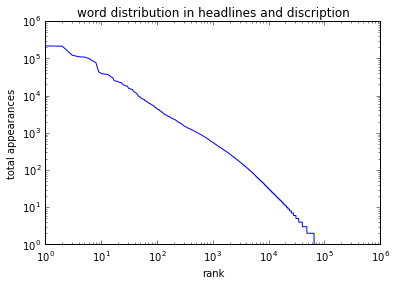

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

from collections import Counter
def get_vocabs(lst):
    text= ' '.join(lst)
    words = text.split()
    w = Counter(words)
    vocab = list(map(lambda x:x[0],sorted(w.items(),key = lambda x:-x[1])))
    v2i = {v:i+start_idx for i,v in enumerate(vocab)}
    v2i['<empty>'] = empty
    v2i['<eos>'] = eos
    i2v = {i:v for v,i in v2i.items()}
    return v2i, i2v, vocab,w    


def get_vocab(lst):
    text = ' '.join(lst)
    vocab = list(set(text.split()))
    v2i = {v:i+start_idx for i,v in enumerate(vocab)}
    v2i['<empty>'] = empty
    v2i['<eos>'] = eos
    i2v = {i:v for v,i in v2i.items()}
    return v2i, i2v, vocab

v2i,i2v,vocab,vocabcounts = get_vocabs(title+content)

In [181]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word
word2idx, idx2word = get_idx(vocab, vocabcount)

In [182]:
len(word2idx)

120404

def loadGloVe(file):
    vocab = []
    embed = []
    with open(file,'r') as f:
        for line in f.readlines():
            row = line.strip().split(' ')
            vocab.append(row[0])
            embed.append(row[1:])
        print ('GloVe loaded')
    return vocab,embed

g_vocab,g_embed = loadGloVe('./glove.6B/glove.6B.50d.txt')

In [85]:
embedding_dim = 50
glove_n_symbols = 400000
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open('./glove.6B/glove.6B.50d.txt', 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = l[1:]
        i += 1
glove_embedding_weights *= globale_scale

In [183]:
glove_embedding_weights.std()

0.064410429768131147

In [184]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [185]:
len(idx2word)

120404

In [186]:
vocab_size = 40000
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.111562136896 std 0.0643832473942
number of tokens, in small vocab, found in glove and copied to embedding 35844 0.8961


In [187]:
embedding.shape

(40000, 50)

In [188]:
glove_thr = 0.5

word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [189]:
len(glove_index_dict)

400000

In [190]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

In [191]:
nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))


# of glove substitutes found 38668


In [192]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.513450899975 lepchenko => sweeting
0.513413909188 keone => umass
0.512856546622 dostoevsky => narrates
0.512776128656 drawcard => iconiq
0.510829579005 nonpublic => planner
0.510243586766 retransmission => guernsey
0.510182186279 kirchhoff => ohm
0.505276643188 physiologist => entomology
0.50477394965 ramtane => pillay
0.50024973722 brite => rsvp


In [193]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [194]:
Y = [[word2idx[token] for token in headline.split()] for headline in title]
len(Y)

10000

In [195]:
len(Y)

10000

(array([  1.53000000e+02,   4.73000000e+02,   4.48000000e+02,
          1.36100000e+03,   1.81600000e+03,   9.75000000e+02,
          1.60900000e+03,   1.19900000e+03,   3.87000000e+02,
          6.00000000e+02,   3.55000000e+02,   1.26000000e+02,
          1.78000000e+02,   1.01000000e+02,   2.90000000e+01,
          5.40000000e+01,   3.20000000e+01,   6.00000000e+00,
          1.90000000e+01,   1.70000000e+01,   8.00000000e+00,
          8.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

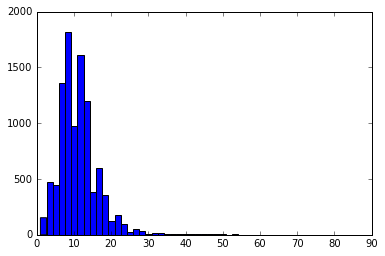

In [196]:
plt.hist(list(map(len,Y)),bins=50)

In [197]:
X = [[word2idx[token] for token in d.split()] for d in content]
len(X)

10000

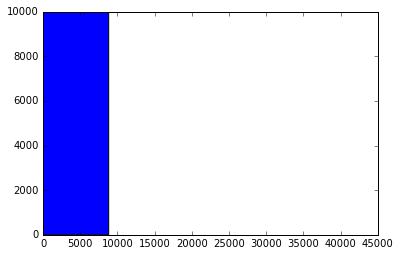

In [198]:
plt.hist(list(map(len,X)),bins=5);
plt.show()

In [199]:
import pickle
with open('floyd-train/data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [200]:
import pickle
with open('floyd-train/data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)

In [ ]:
import numpy as np
g_vocab_size = len(g_vocab)
embedding_dim = len(g_embed[0])
g_embedding = np.asarray(g_embed)

In [17]:
g_embedding=g_embedding.astype(float)

In [18]:
g_embedding*=0.1
g_embedding.std()

0.064410429768131147

In [19]:
glove_v2i = {w:i for i,w in enumerate(g_vocab)}

In [20]:
for w,i in glove_v2i.items():
    w = w.lower()
    if w not in glove_v2i:
        glove_v2i[w] = i

In [21]:
len(glove_v2i)

400000

In [22]:
vocab_size = len(v2i)
vocab_size

33435

In [23]:
np.random.seed(seed)
scale = g_embedding.std()*np.sqrt(12)/2
embedding = np.random.uniform(low = -scale,high = scale,size = (vocab_size,embedding_dim))


In [24]:
c = 0
for i in range(vocab_size):
    w = i2v[i]
    g = glove_v2i.get(w)
    if g is not None:
        embedding[i,:] = g_embedding[g,:]
        c+=1
c

26806

In [25]:
embedding.shape

(33435, 50)

In [26]:
word2glove = {}
for w in v2i:
    if w in glove_v2i:
        g = w
    elif w.lower() in glove_v2i:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_v2i:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_v2i:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [27]:
glove_thr = 0.5
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

In [28]:
nb_unknown_words = 100

glove_match = []
for w,idx in v2i.items():
    #if idx >= vocab_size-nb_unknown_words and 
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_v2i[word2glove[w]]
        gweight = g_embedding[gidx,:].copy()
    # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if i2v[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

# of glove substitutes found 73


In [29]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', i2v[sub])

0.629425057878 telegraphed => backtrack
0.623519892539 arter => biswal
0.62130709922 jerk => biting
0.608992277812 allstate => insurer
0.600587003929 clackmannanshire => ashbourne
0.599489489987 guinness => camelot
0.58895181011 très => déu
0.579574030722 solitudes => betwixt
0.554579992725 ntra => ea
0.546151532025 adonis => renuka


In [30]:
glove_idx2idx = {(v2i[w],embedding_idx) for  w, embedding_idx, _ in glove_match}

In [44]:
Y[3]

[]

In [41]:
Y = []
for headline in title:
    item_list = []
    for token in headline.split():
        try:
            item_list.append(v2i[token])
        except:
            print('Token not found: ' + token )
    Y.append(item_list)

Token not found: worcester
Token not found: breakfast
Token not found: club
Token not found: for
Token not found: veterans
Token not found: gives
Token not found: hunger
Token not found: its
Token not found: marching
Token not found: orders
Token not found: jumpshot
Token not found: gives
Token not found: marketers
Token not found: renewed
Token not found: visibility
Token not found: into
Token not found: paid
Token not found: and
Token not found: organic
Token not found: keywords
Token not found: with
Token not found: launch
Token not found: of
Token not found: jumpshot
Token not found: elite
Token not found: the
Token not found: return
Token not found: of
Token not found: the
Token not found: nike
Token not found: air
Token not found: max
Token not found: sensation
Token not found: has
Token not found: 80’s
Token not found: babies
Token not found: hyped
Token not found: !
Token not found: this
Token not found: new
Token not found: dating
Token not found: app
Token not found: will
Tok

(array([  17.,   16.,   30.,   56.,   57.,  152.,   96.,  108.,   92.,
          63.,  124.,   33.,   36.,   21.,   20.,   29.,   12.,    7.,
           6.,    4.,    6.,    3.,    1.,    1.,    1.,    3.,    2.,
           0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ,  14.2,  15.4,  16.6,  17.8,  19. ,  20.2,  21.4,
         22.6,  23.8,  25. ,  26.2,  27.4,  28.6,  29.8,  31. ,  32.2,
         33.4,  34.6,  35.8,  37. ,  38.2,  39.4,  40.6,  41.8,  43. ,
         44.2,  45.4,  46.6,  47.8,  49. ,  50.2,  51.4,  52.6,  53.8,
         55. ,  56.2,  57.4,  58.6,  59.8,  61. ]),
 <a list of 50 Patch objects>)

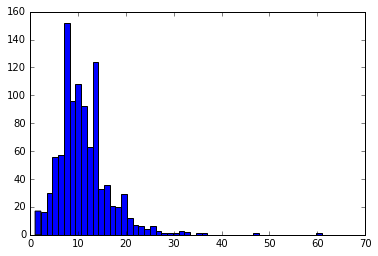

In [33]:
#y_df = pd.DataFrame(Y)
plt.hist(list(map(len,Y)),bins=50)

In [34]:
X = []
for c in content:
    item_list =[]
    for token in c.split():
        try:
            item_list.append(v2i[token])
        except:
            print ('Token not found', token)
    X.append(item_list)

Token not found wormelow’s
Token not found renton
Token not found dimapur
Token not found nouran
Token not found 
Token not found fxstreet
Token not found sreenshot
Token not found kaneland—a
Token not found lille
Token not found bothell
Token not found ameinfo
Token not found geier’s
Token not found modrobert
Token not found mil
Token not found schuyler
Token not found stu
Token not found mosquito
Token not found salvador
Token not found psychologists
Token not found financeinvestments
Token not found oldwick
Token not found videoimagetaupau
Token not found capping
Token not found haifa
Token not found hampton
Token not found deferral
Token not found searcy
Token not found “mountains
Token not found whoops
Token not found gentlemen
Token not found firefly
Token not found nike’s
Token not found katee
Token not found mil
Token not found cture
Token not found ttwo
Token not found thiruvananthapuram
Token not found manny
Token not found sharetwitter
Token not found maktoob
Token not foun

(array([ 986.,   12.,    1.,    0.,    1.]),
 array([    25. ,   2204.2,   4383.4,   6562.6,   8741.8,  10921. ]),
 <a list of 5 Patch objects>)

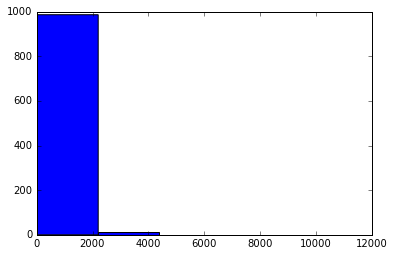

In [35]:
plt.hist(list(map(len,X)),bins = 5)

In [251]:
import pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, i2v, v2i, glove_idx2idx),fp,-1)

In [252]:
import pickle
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)

In [ ]:
from tensorflow.contrib import learn
#init vocab processor
vocab_processor = learn.preprocessing.VocabularyProcessor(200)
#fit the vocab from glove
pretrain = vocab_processor.fit(vocab)
#transform inputs
x = np.array(list(vocab_processor.transform(your_raw_input)))


In [6]:
words = []
for line in d.rsplit('\n'):
    for word in line.split(' '):
        words.append(word)

In [12]:
from nltk.tokenize import word_tokenize
w = word_tokenize(data.content[0])

In [210]:
list(range(1,62))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61]

In [18]:
words[:10]

['VETERANS',
 'saluted',
 'Worcester',
 "'",
 's',
 'first',
 'ever',
 'breakfast',
 'club',
 'for']

In [19]:
w[:10]

['VETERANS',
 'saluted',
 'Worcester',
 "'s",
 'first',
 'ever',
 'breakfast',
 'club',
 'for',
 'ex-soldiers']

In [3]:
title = []
with open('signalmedia-1m.jsonl') as f:
    for line in f:
        objs = ijson.items(f, ['title','content'])
        title.append(objs)

In [25]:
json.loads(mylist[0])['content']

'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nThe Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. \n \nThe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nFather-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. \n \nHe said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"We even had an old chap travel from Droitwich and he was late on parade by three hours. \n \n"It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards." \n \nHe said the management at the pub ha

In [14]:
dd = []
with open('d.json') as f:
    d = json.load(f)

JSONDecodeError: Extra data: line 1 column 2666 (char 2665)

In [33]:
import pandas as pd
d = pd.DataFrame(title)

ValueError: I/O operation on closed file.

In [24]:
mylist[353]

'{"id":"c5ee235c-b826-4758-ad9e-deb5923fcc7c","content":"BY MERIANNE GRACE ERE\\u00d1ETA \\n \\nILOILO City \\u2013 Vice Mayor Jose Espinosa III does not know how to count? \\n \\nHe should not have included himself among the councilors eligible to vote for the proposed ordinance granting a franchise to an applicant seeking to operate a cockpit, said Councilor Lyndon Acap. \\n \\nOf the 12 councilors present during the Sangguniang Panlungsod\\u2019s (SP) session on Tuesday, seven voted in favor of Rockwell and Lumber that plans to operate a cockpit in Barangay Esteban, Lapuz district. \\n \\nAccording to Acap, seven was the majority vote or more than half of 12. \\n \\nThe chairman of the committee on games, amusements and professional sports said he will seek a \\u201creconsideration.\\u201d \\n \\n\\u201cI went to Ma\\u2019am Ruth (Arroyo) \\u2013 the SP secretary \\u2013 kon may insakto nga pamaagi (on what is the proper procedure to do so),\\u201d said Acap whose committee endorsed